# Initialize Modules and Paths

In [1]:
# load modules

import numpy as np
import os
import h5py
from scipy.optimize import fsolve

import completeness

import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.serif'] = 'STIXGeneral'



In [13]:
# define paths

path_main = os.environ['WDIR_halo_model']
path_figures = path_main + 'Figures/'
path_DM_cat = path_main + 'catalogs/DM/'
path_SFH_cat = path_main + 'catalogs/SFH/'
path_SP_cat = path_main + 'catalogs/SP/'
path_SP_cat_00 = path_main + 'catalogs/SP/0.0/'
path_SP_cat_02 = path_main + 'catalogs/SP/0.2/'
path_SP_cat_04 = path_main + 'catalogs/SP/0.4/'
path_SP_cat_06 = path_main + 'catalogs/SP/0.6/'


In [6]:
# define important parameters

volume_box = 100.0**3  # in Mpc^-3




# Get Data from ody

In [7]:
# get the data in terminal

path_ody = '/n/eisenstein_lab/Users/stacchella/halo_model/catalogs/'

print 'scp stacchella@odyssey.rc.fas.harvard.edu:/' + path_ody + 'SFH/*.hdf5' + ' ' + path_SFH_cat
print 'scp stacchella@odyssey.rc.fas.harvard.edu:/' + path_ody + 'SP/*.hdf5' + ' ' + path_SP_cat



scp stacchella@odyssey.rc.fas.harvard.edu://n/eisenstein_lab/Users/stacchella/halo_model/catalogs/SFH/*.hdf5 /Users/sandrotacchella/ASTRO/JWST/halo_model/catalogs/SFH/
scp stacchella@odyssey.rc.fas.harvard.edu://n/eisenstein_lab/Users/stacchella/halo_model/catalogs/SP/*.hdf5 /Users/sandrotacchella/ASTRO/JWST/halo_model/catalogs/SP/


# Comparison UV LFs

In [8]:
# define functions

def compute_LF(SP_file_name, volume_box, bin_size=0.25, cumulative=False, add_dust=False, redshift_in=None, completeness_correction=False, completeness_correction_type='parameterized'):
    '''
    input:
      SP_file_name:    hdf5 filename that contains luminosities
      volume_box:      volume of simulation box in Mpc^-3
      cumulative:      True/False for computing cumulative LF
      add_dust:        True/False for adding dust attenuation to UV mags
      redshift_in:     redshift considered, needed for add_dust and completeness_correction
      completeness_correction:  True/False for applying completeness correction
    '''
    cat_SP = h5py.File(SP_file_name, 'r')
    mag_list = -48.6-2.5*np.log10(cat_SP['luminosities/luminosity_0'][:, 2]/(4*np.pi*(3.086e+19)**2))
    idx_good = np.isfinite(mag_list)
    mag_list = mag_list[idx_good]
    mag_bins = np.arange(np.max([-25.0, np.min(mag_list)]), np.min([-12.5, np.max(mag_list)]), bin_size)
    mag_bins_center = mag_bins[:-1] + 0.5*np.diff(mag_bins)
    if completeness_correction:
        if (completeness_correction_type=='numerical'):
            weights = 10**completeness.get_completeness_correction_numerical(np.log10(cat_SP['DM/DM_M'][:][idx_good]), redshift_in)
        elif (completeness_correction_type=='parameterized'):
            weights = 10**completeness.get_completeness_correction_parametrized(np.log10(cat_SP['DM/DM_M'][:][idx_good]), redshift_in)
    else:
        weights = None
    hist, bin_edges = np.histogram(mag_list, bins=mag_bins, weights=weights)
    if add_dust:
        mag_bins_center_d = add_dust_attenuation(mag_bins_center, redshift_in)
    else:
        mag_bins_center_d = mag_bins_center     
    if cumulative:
        LFcum = np.cumsum(hist)/volume_box
        return(mag_bins_center_d, LFcum)
    else:
        LF = hist/(np.diff(mag_bins)*volume_box)
        return(mag_bins_center_d, LF)


def get_dust_attenuation(magUV_in, redshift_in, with_scatter=False):
    '''
    This function computes the dust attenuation at 1600 A (A1600)
    from the Bouwens et al 2015 relation; used to do the dust 
    correction.
    '''
    # ensure inputs are arrays
    if type(magUV_in) is not np.ndarray:
        magUV_in = np.array([magUV_in])
    if type(redshift_in) is not np.ndarray:
        redshift_in = np.array([redshift_in])
    # values for beta-MUV relation from Bouwens et al 2015
    B15_z_list = np.array([2.5, 3.8, 5.0, 5.9, 7.0, 8.0])
    B15_beta_list = np.array([-1.70, -1.85, -1.91, -2.00, -2.05, -2.13])
    B15_dbdM_list = np.array([-0.20, -0.11, -0.14, -0.20, -0.20, -0.15])
    # interpolate beta-MUV relation
    beta_value = np.interp(redshift_in, B15_z_list, B15_beta_list, left=B15_beta_list[0], right=np.nan)
    dbdM_value = np.interp(redshift_in, B15_z_list, B15_dbdM_list, left=B15_dbdM_list[0], right=np.nan)
    # get average beta
    avg_b = dbdM_value*(magUV_in+19.5) + beta_value
    # convert beta to A1600
    if with_scatter:
        A1600 = 4.43 + 1.99*(avg_b + np.random.normal(loc=0.0, scale=0.34, size=len(avg_b)))
    else:
        A1600 = 4.43 + 0.2*np.log(10)*1.99**2*0.34**2+1.99*avg_b
    A1600[np.isnan(A1600)] = np.zeros(np.sum(np.isnan(A1600)))
    A1600[A1600 < 0.0] = np.zeros(np.sum(A1600 < 0.0))
    return(A1600)


def fct_solve(mag_with_dust, mag_without_dust, redshift):
    return(mag_without_dust-(mag_with_dust-get_dust_attenuation(mag_with_dust, redshift)))


def add_dust_attenuation(magUV_in, redshift_in, with_scatter=False):
    '''
    Adds dust according to the Bouwens et al 2015 relation.
    '''
    mag_with_dust = fsolve(fct_solve, magUV_in, args=(magUV_in, redshift_in))
    return(mag_with_dust)


def UV_LF_Bouwens15(mag_in, z, num_of_draws=1000, cumulative=True, do_dust_corr=True, with_scatter=False):
    '''
    This returns the UV LF (mags and phis) of Bouwens et al 2015.
    '''
    # take random draw from error distribution
    MUV_list = np.random.normal(loc=-20.95, scale=0.1, size=num_of_draws)+np.random.normal(loc=0.01, scale=0.06, size=num_of_draws)*(z-6.0)
    phi_list = np.random.normal(loc=0.47, scale=0.1, size=num_of_draws)*np.power(10, np.random.normal(loc=-0.27, scale=0.05, size=num_of_draws)*(z-6.0))*10**-3  # in Mpc
    alpha_list = np.random.normal(loc=-1.87, scale=0.05, size=num_of_draws)+np.random.normal(loc=-0.1, scale=0.03, size=num_of_draws)*(z-6.0)
    # print median
    print '---------------------'
    print 'redshift = ', z
    print 'MUV = ', np.round(np.median(MUV_list), 2)
    print 'phi (x10^-3) = ', np.round(np.median(phi_list)*10**3, 2)
    print 'alpha = ', np.round(np.median(alpha_list), 2)
    # correct for dust
    if do_dust_corr:
        AUV = get_dust_attenuation(mag_in, z, with_scatter=with_scatter)
        mag = mag_in - AUV
    else:
        mag = mag_in
    # get UV LF
    ii = 0
    UV_LF_list = phi_list[ii]*(np.log(10)/2.5)*np.power(10, -0.4*(mag_in-MUV_list[ii])*(alpha_list[ii]+1.0))*np.exp(-1.0*np.power(10.0, -0.4*(mag_in-MUV_list[ii])))
    for ii in np.arange(1, num_of_draws):
        UV_LF_ii = phi_list[ii]*(np.log(10)/2.5)*np.power(10, -0.4*(mag_in-MUV_list[ii])*(alpha_list[ii]+1.0))*np.exp(-1.0*np.power(10.0, -0.4*(mag_in-MUV_list[ii])))
        UV_LF_list = np.vstack([UV_LF_list, UV_LF_ii])
    UV_LF_median = np.percentile(UV_LF_list, 50, axis=0)
    UV_LF_P16 = np.percentile(UV_LF_list, 16, axis=0)
    UV_LF_P84 = np.percentile(UV_LF_list, 84, axis=0)
    if cumulative:
        UV_LF_cum_median = []
        UV_LF_cum_P16 = []
        UV_LF_cum_P84 = []
        for ii_mag in mag_in:
            idx = (mag_in < ii_mag)
            UV_LF_cum_median = np.append(UV_LF_cum_median, np.trapz(UV_LF_median[idx], mag_in[idx]))
            UV_LF_cum_P16 = np.append(UV_LF_cum_P16, np.trapz(UV_LF_P16[idx], mag_in[idx]))
            UV_LF_cum_P84 = np.append(UV_LF_cum_P84, np.trapz(UV_LF_P84[idx], mag_in[idx]))
        return(mag, UV_LF_cum_median, UV_LF_cum_P16, UV_LF_cum_P84)
    else:
        return(mag, UV_LF_median, UV_LF_P16, UV_LF_P84)


def plot_datapoints_observations(axes, dictionary, redshift, color, label):
    idx_no_upper_limit = (dictionary[redshift][2]>0.0)
    idx_upper_limit = ~idx_no_upper_limit
    # plot errorbar
    error_bar_neg = np.log10(dictionary[redshift][1][idx_no_upper_limit])-np.log10(dictionary[redshift][1][idx_no_upper_limit]-dictionary[redshift][2][idx_no_upper_limit])
    error_bar_pos = np.log10(dictionary[redshift][1][idx_no_upper_limit]+dictionary[redshift][3][idx_no_upper_limit])-np.log10(dictionary[redshift][1][idx_no_upper_limit])
    axes.errorbar(dictionary[redshift][0][idx_no_upper_limit], np.log10(dictionary[redshift][1][idx_no_upper_limit]), yerr=[error_bar_neg, error_bar_pos], fmt='o', color=color, capsize=3, label=label)
    # plot upper limit
    axes.errorbar(dictionary[redshift][0][idx_upper_limit], np.log10(dictionary[redshift][1][idx_upper_limit]), yerr=0.4, fmt='.', markersize=0, color=color, capsize=3, uplims=True)



In [9]:
# make dictionary with observed LFs

LF_obs_dict = {}

# z=4
mag_list = np.array([-22.69, -22.19, -21.69, -21.19, -20.69, -20.19, -19.69, -19.19, -18.69, -18.19, -17.69, -16.94, -15.94])
phi_list = np.array([0.000003, 0.000015, 0.000134, 0.000393, 0.000678, 0.001696, 0.002475, 0.002984, 0.005352, 0.006865, 0.010473, 0.024580, 0.025080])
phi_err_list_neg = np.array([0.0000029, 0.000009, 0.000023, 0.000040, 0.000063, 0.000113, 0.000185, 0.000255, 0.000446, 0.001043, 0.002229, 0.003500, 0.007860])
phi_err_list_pos = np.array([0.000004, 0.000009, 0.000023, 0.000040, 0.000063, 0.000113, 0.000185, 0.000255, 0.000446, 0.001043, 0.002229, 0.003500, 0.007860])
LF_obs_dict['4'] = np.array([mag_list, phi_list, phi_err_list_neg, phi_err_list_pos])

# z=5
mag_list = np.array([-23.11, -22.61, -22.11, -21.61, -21.11, -20.61, -20.11, -19.61, -19.11, -18.36, -17.36, -16.36])
phi_list = np.array([0.000002, 0.000006, 0.000034, 0.000101, 0.000265, 0.000676, 0.001029, 0.001329, 0.002085, 0.004460, 0.008600, 0.024400])
phi_err_list_neg = np.array([0.0000019, 0.000003, 0.000008, 0.000014, 0.000025, 0.000046, 0.000067, 0.000094, 0.000171, 0.000540, 0.001760, 0.001760])
phi_err_list_pos = np.array([0.000002, 0.000003, 0.000008, 0.000014, 0.000025, 0.000046, 0.000067, 0.000094, 0.000171, 0.000540, 0.001760, 0.001760])
LF_obs_dict['5'] = np.array([mag_list, phi_list, phi_err_list_neg, phi_err_list_pos])

# z=6
mag_list = np.array([-22.52, -22.02, -21.52, -21.02, -20.52, -20.02, -19.52, -18.77, -17.77, -16.77])
phi_list = np.array([0.000002, 0.000015, 0.000053, 0.000176, 0.000320, 0.000698, 0.001246, 0.001900, 0.006680, 0.013640])
phi_err_list_neg = np.array([0.0000019, 0.000006, 0.000012, 0.000025, 0.000041, 0.000083, 0.000137, 0.000320, 0.001380, 0.004200])
phi_err_list_pos = np.array([0.000002, 0.000006, 0.000012, 0.000025, 0.000041, 0.000083, 0.000137, 0.000320, 0.001380, 0.004200])
LF_obs_dict['6'] = np.array([mag_list, phi_list, phi_err_list_neg, phi_err_list_pos])

# z=7
mag_list = np.array([-22.66, -22.16, -21.66, -21.16, -20.66, -20.16, -19.66, -19.16, -18.66, -17.91, -16.91])
phi_list = np.array([0.000002, 0.000001, 0.000033, 0.000048, 0.000193, 0.000309, 0.000654, 0.000907, 0.001717, 0.005840, 0.008500])
phi_err_list_neg = np.array([-99.0, 0.0000009, 0.000009, 0.000015, 0.000034, 0.000061, 0.000100, 0.000177, 0.000478, 0.001460, 0.002940])
phi_err_list_pos = np.array([-99.0, 0.000002, 0.000009, 0.000015, 0.000034, 0.000061, 0.000100, 0.000177, 0.000478, 0.001460, 0.002940])
LF_obs_dict['7'] = np.array([mag_list, phi_list, phi_err_list_neg, phi_err_list_pos])

# z=8
mag_list = np.array([-22.87, -22.37, -21.87, -21.37, -20.87, -20.37, -19.87, -19.37, -18.62, -17.62])
phi_list = np.array([0.000002, 0.000002, 0.000005, 0.000013, 0.000058, 0.000060, 0.000331, 0.000533, 0.001060, 0.002740])
phi_err_list = np.array([-99.0, -99.0, 0.000003, 0.000005, 0.000015, 0.000026, 0.000104, 0.000226, 0.000340, 0.001040])
LF_obs_dict['8'] = np.array([mag_list, phi_list, phi_err_list, phi_err_list])

# z=10
mag_list = np.array([-22.25, -21.25, -20.25, -19.25, -18.25, -17.25])
phi_list = np.array([0.017*10**-4, 0.010*10**-4, 0.100*10**-4, 0.340*10**-4, 1.900*10**-4, 6.300*10**-4])
phi_err_list_neg = np.array([-99.0, 0.008*10**-4, 0.050*10**-4, 0.220*10**-4, 1.200*10**-4, 5.200*10**-4])
phi_err_list_pos = np.array([-99.0, 0.022*10**-4, 0.100*10**-4, 0.450*10**-4, 2.500*10**-4, 14.90*10**-4])
LF_obs_dict['10'] = np.array([mag_list, phi_list, phi_err_list_neg, phi_err_list_pos])



## Compare non-cumulative UV LF 

In [10]:
# get observed UV LF from Bouwens et al 2015

list_mag_in = np.linspace(-30.0, -15.0, num=1000)
list_mag_z4, UVLF_z4_median, UVLF_z4_P16, UVLF_z4_P84 = UV_LF_Bouwens15(list_mag_in, 4.0, num_of_draws=1000, cumulative=False, do_dust_corr=False)
list_mag_z6, UVLF_z6_median, UVLF_z6_P16, UVLF_z6_P84 = UV_LF_Bouwens15(list_mag_in, 6.0, num_of_draws=1000, cumulative=False, do_dust_corr=False)
list_mag_z8, UVLF_z8_median, UVLF_z8_P16, UVLF_z8_P84 = UV_LF_Bouwens15(list_mag_in, 8.0, num_of_draws=1000, cumulative=False, do_dust_corr=False)
list_mag_z10, UVLF_z10_median, UVLF_z10_P16, UVLF_z10_P84 = UV_LF_Bouwens15(list_mag_in, 10.0, num_of_draws=1000, cumulative=False, do_dust_corr=False)


---------------------
redshift =  4.0
MUV =  -20.96
phi (x10^-3) =  1.63
alpha =  -1.67
---------------------
redshift =  6.0
MUV =  -20.95
phi (x10^-3) =  0.47
alpha =  -1.87
---------------------
redshift =  8.0
MUV =  -20.94
phi (x10^-3) =  0.13
alpha =  -2.07
---------------------
redshift =  10.0
MUV =  -20.92
phi (x10^-3) =  0.04
alpha =  -2.28


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10


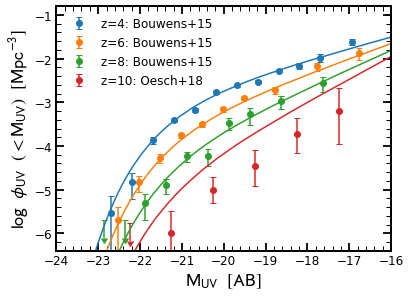

In [11]:
# test plotting of UV LF

redshift_plot = ['4', '6', '8', '10']
color_plot = ['C0', 'C1', 'C2', 'C3']
label_plot = ['z=4: Bouwens+15', 'z=6: Bouwens+15', 'z=8: Bouwens+15', 'z=10: Oesch+18']


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))

# plot data points from stepwise determination using SWML method
for ii in range(len(redshift_plot)):
    plot_datapoints_observations(ax, LF_obs_dict, redshift_plot[ii], color_plot[ii], label_plot[ii])

# plot STY79 determinations of the Schechter Parameters (best fit from Bouwens)
# different from Oesch at z~10!
ax.plot(list_mag_z4, np.log10(UVLF_z4_median), '-', color=color_plot[0])
ax.plot(list_mag_z6, np.log10(UVLF_z6_median), '-', color=color_plot[1])
ax.plot(list_mag_z8, np.log10(UVLF_z8_median), '-', color=color_plot[2])
ax.plot(list_mag_z10, np.log10(UVLF_z10_median), '-', color=color_plot[3])
    

ax.set_xlabel(r'$\mathrm{M}_{\rm UV}\/\/\/\/[\mathrm{AB}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\phi_{\rm UV}\/\/\/\/(<\mathrm{M}_{\rm UV})\/\/\/\/[\mathrm{Mpc}^{-3}]$', fontsize=18)

ax.set_xlim([-24, -16])
ax.set_ylim([-6.4, -0.8])

plt.legend(frameon=False, fontsize=12)
plt.savefig(path_figures + 'UV_LF_test.pdf', bbox_inches='tight')
plt.show()

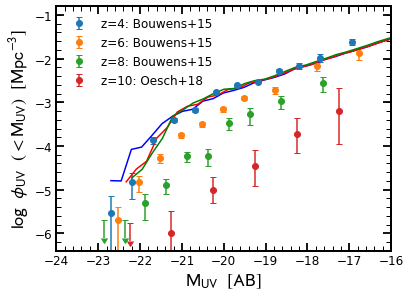

In [14]:
redshift_plot = ['4', '6', '8', '10']
color_plot = ['C0', 'C1', 'C2', 'C3']
mag_bin_size = [0.3, 0.5, 0.6, 0.8]
label_plot = ['z=4: Bouwens+15', 'z=6: Bouwens+15', 'z=8: Bouwens+15', 'z=10: Oesch+18']


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))

# plot data points from stepwise determination using SWML method
for ii in range(len(redshift_plot)):
    plot_datapoints_observations(ax, LF_obs_dict, redshift_plot[ii], color_plot[ii], label_plot[ii])


#for ii in range(len(redshift_plot)):
#    mag_bins_center, LF = compute_LF(path_SP_cat_00 + 'SFH_z' + redshift_plot[ii] + '_constant_with_L.hdf5', volume_box, bin_size=mag_bin_size[ii], cumulative=False, add_dust=True, redshift_in=float(redshift_plot[ii]), completeness_correction=True, completeness_correction_type='parameterized')
#    ax.plot(mag_bins_center, np.log10(LF), '-', color=color_plot[ii])


mag_bins_center, LF = compute_LF(path_SP_cat_00 + 'SFH_z4_constant_with_L.hdf5', volume_box, bin_size=0.3, cumulative=False, add_dust=True, redshift_in=4.0, completeness_correction=True, completeness_correction_type='parameterized')
ax.plot(mag_bins_center, np.log10(LF), '-', color='blue')

mag_bins_center, LF = compute_LF(path_SP_cat_04 + 'SFH_z4_constant_with_L.hdf5', volume_box, bin_size=0.3, cumulative=False, add_dust=True, redshift_in=4.0, completeness_correction=True, completeness_correction_type='parameterized')
ax.plot(mag_bins_center, np.log10(LF), '-', color='red')

mag_bins_center, LF = compute_LF(path_SP_cat_06 + 'SFH_z4_constant_with_L.hdf5', volume_box, bin_size=0.3, cumulative=False, add_dust=True, redshift_in=4.0, completeness_correction=True, completeness_correction_type='parameterized')
ax.plot(mag_bins_center, np.log10(LF), '-', color='green')


    
#for ii in range(len(redshift_plot)):
#    mag_bins_center, LF = compute_LF(path_SP_cat_00 + 'SFH_z' + redshift_plot[ii] + '_constant_with_L.hdf5', volume_box, bin_size=mag_bin_size[ii], cumulative=False, add_dust=True, redshift_in=float(redshift_plot[ii]), completeness_correction=False)
#    ax.plot(mag_bins_center, np.log10(LF), '--', color=color_plot[ii])

    
ax.set_xlabel(r'$\mathrm{M}_{\rm UV}\/\/\/\/[\mathrm{AB}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\phi_{\rm UV}\/\/\/\/(<\mathrm{M}_{\rm UV})\/\/\/\/[\mathrm{Mpc}^{-3}]$', fontsize=18)

ax.set_xlim([-24, -16])
ax.set_ylim([-6.4, -0.8])

plt.legend(frameon=False, fontsize=12)
plt.savefig(path_figures + 'UV_LF_comparison.pdf', bbox_inches='tight')
plt.show()



In [18]:
# uv bright halos

cat_SP = h5py.File(path_SP_cat_04 + 'SFH_z4_constant_with_L.hdf5', 'r')
mag_list = -48.6-2.5*np.log10(cat_SP['luminosities/luminosity_0'][:, 2]/(4*np.pi*(3.086e+19)**2))


In [19]:
idx_bright = (mag_list < -23.0)
np.sum(idx_bright)

43

In [20]:
np.log10(cat_SP['DM/DM_M'][:][idx_bright])

array([12.04385256, 12.06101516, 11.9414246 , 11.57817069, 12.00165896,
       11.4725782 , 12.02631835, 12.13781587, 12.21708988, 11.77864484,
       11.65472932, 12.02379292, 12.06415549, 11.62106679, 11.66840913,
       11.80927057, 11.85532678, 11.45408918, 12.44016846, 11.5316149 ,
       11.64826588, 11.74829511, 11.9498625 , 11.64465139, 11.70598715,
       11.63455575, 11.351357  , 11.93287308, 11.71662663, 11.91797998,
       11.74549536, 11.84981503, 11.81040755, 12.31750335, 11.70445004,
       11.64051706, 11.49342772, 11.906439  , 11.73239573, 11.2398135 ,
       11.51213657, 11.69665871, 11.50909357])

## Compare cumulative UV LFs 

In [12]:
# get observed, cumulative UV LF from Bouwens et al 2015

list_mag_in = np.linspace(-30.0, -15.0, num=1000)
list_mag_z4_cum, UVLF_z4_cum_median, UVLF_z4_cum_P16, UVLF_z4_cum_P84 = UV_LF_Bouwens15(list_mag_in, 3.8, num_of_draws=1000, cumulative=True, do_dust_corr=False)
list_mag_z6_cum, UVLF_z6_cum_median, UVLF_z6_cum_P16, UVLF_z6_cum_P84 = UV_LF_Bouwens15(list_mag_in, 6.0, num_of_draws=1000, cumulative=True, do_dust_corr=False)
list_mag_z8_cum, UVLF_z8_cum_median, UVLF_z8_cum_P16, UVLF_z8_cum_P84 = UV_LF_Bouwens15(list_mag_in, 8.0, num_of_draws=1000, cumulative=True, do_dust_corr=False)


---------------------
redshift =  3.8
MUV =  -20.97
phi (x10^-3) =  1.85
alpha =  -1.65
---------------------
redshift =  6.0
MUV =  -20.95
phi (x10^-3) =  0.46
alpha =  -1.87
---------------------
redshift =  8.0
MUV =  -20.92
phi (x10^-3) =  0.14
alpha =  -2.07


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


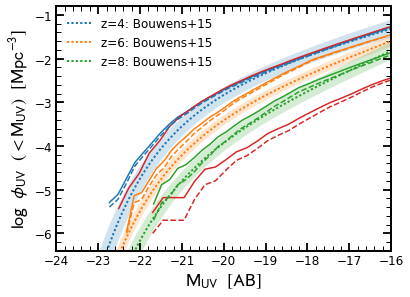

In [14]:
redshift_plot = ['4', '6', '8', '10']
color_plot = ['C0', 'C1', 'C2', 'C3']
label_plot = ['z=4: Bouwens+15', 'z=6: Bouwens+15', 'z=8: Bouwens+15', 'z=10: Oesch+18']


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))

ax.plot(list_mag_z4_cum, np.log10(UVLF_z4_cum_median), ':', color=color_plot[0], lw=2, label=label_plot[0])
ax.fill_between(list_mag_z4, np.log10(UVLF_z4_cum_P16), np.log10(UVLF_z4_cum_P84), color=color_plot[0], lw=0.0, alpha=0.2)
ax.plot(list_mag_z6_cum, np.log10(UVLF_z6_cum_median), ':', color=color_plot[1], lw=2, label=label_plot[1])
ax.fill_between(list_mag_z6, np.log10(UVLF_z6_cum_P16), np.log10(UVLF_z6_cum_P84), color=color_plot[1], lw=0.0, alpha=0.2)
ax.plot(list_mag_z8_cum, np.log10(UVLF_z8_cum_median), ':', color=color_plot[2], lw=2, label=label_plot[2])
ax.fill_between(list_mag_z8, np.log10(UVLF_z8_cum_P16), np.log10(UVLF_z8_cum_P84), color=color_plot[2], lw=0.0, alpha=0.2)


for ii in range(len(redshift_plot)):
    mag_bins_center, LF = compute_LF(path_SP_cat_00 + 'SFH_z' + redshift_plot[ii] + '_constant_with_L.hdf5', volume_box, cumulative=True, add_dust=True, redshift_in=float(redshift_plot[ii]), completeness_correction=True, completeness_correction_type='numerical')
    ax.plot(mag_bins_center, np.log10(LF), '-', color=color_plot[ii])

    
mag_bins_center, LF = compute_LF(path_SP_cat_02 + 'SFH_z4_constant_with_L.hdf5', volume_box, bin_size=0.3, cumulative=True, add_dust=True, redshift_in=4.0, completeness_correction=True, completeness_correction_type='numerical')
ax.plot(mag_bins_center, np.log10(LF), '-', color=color_plot[ii])

    
for ii in range(len(redshift_plot)):
    mag_bins_center, LF = compute_LF(path_SP_cat_00 + 'SFH_z' + redshift_plot[ii] + '_constant_with_L.hdf5', volume_box, cumulative=True, add_dust=True, redshift_in=float(redshift_plot[ii]), completeness_correction=False)
    ax.plot(mag_bins_center, np.log10(LF), '--', color=color_plot[ii])

    
ax.set_xlabel(r'$\mathrm{M}_{\rm UV}\/\/\/\/[\mathrm{AB}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\phi_{\rm UV}\/\/\/\/(<\mathrm{M}_{\rm UV})\/\/\/\/[\mathrm{Mpc}^{-3}]$', fontsize=18)

ax.set_xlim([-24, -16])
ax.set_ylim([-6.4, -0.8])

plt.legend(frameon=False, fontsize=12)
plt.savefig(path_figures + 'UV_LF_cumulative.pdf', bbox_inches='tight')
plt.show()





# Comparison SFR Functions

In [19]:
# define functions

def compute_SFR(cat_obj, time_interval):
    '''
    Computes average SFR over certain time interval
    from given cat_obj file. 
    
    Input:
      cat_obj       : object with SFH
      time_interval : time in Myr
      
    Output:
      SFR           : SFR in Msun/yr
      
    '''
    # load SFH for given time interval
    idx_time_interval = (cat_obj['SFH/SFH_time'][:] >= (cat_obj['SFH/SFH_time'][:][-1]-time_interval))
    SFR_list = cat_obj['SFH/SFH_SFR'][:, idx_time_interval]
    time_list = cat_obj['SFH/SFH_time'][idx_time_interval]
    time_interval = (time_list[-1]-time_list[0])*10**6  # in yrs
    # compute mass
    mass_tot_list = np.trapz(SFR_list, time_list*10**6)
    # compute average SFR
    SFR = mass_tot_list/time_interval
    return(SFR)


def compute_SFR_Fct(SP_file_name, volume_box, bin_size=0.1, cumulative=False, redshift_in=None, completeness_correction=False, completeness_correction_type='parameterized'):
    '''
    input:
      SP_file_name:    hdf5 filename that contains luminosities
      volume_box:      volume of simulation box in Mpc^-3
      cumulative:      True/False for computing cumulative LF
      add_dust:        True/False for adding dust attenuation to UV mags
      redshift_in:     redshift considered, needed for add_dust and completeness_correction
      completeness_correction:  True/False for applying completeness correction
    '''
    cat_SP = h5py.File(SP_file_name, 'r')
    SFR_list = np.log10(compute_SFR(cat_SP, 200.0))
    idx_good = np.isfinite(SFR_list)
    SFR_list = SFR_list[idx_good]
    SFR_bins = np.arange(np.max([-2.0, np.min(SFR_list)]), np.min([3.0, np.max(SFR_list)]), bin_size)
    SFR_bins_center = SFR_bins[:-1] + 0.5*np.diff(SFR_bins)
    if completeness_correction:
        if (completeness_correction_type=='numerical'):
            weights = 10**completeness.get_completeness_correction_numerical(np.log10(cat_SP['DM/DM_M'][:][idx_good]), redshift_in)
        elif (completeness_correction_type=='parameterized'):
            weights = 10**completeness.get_completeness_correction_parametrized(np.log10(cat_SP['DM/DM_M'][:][idx_good]), redshift_in)
    else:
        weights = None
    hist, bin_edges = np.histogram(SFR_list, bins=SFR_bins, weights=weights)
    if cumulative:
        SFR_Fctcum = np.cumsum(hist[::-1])[::-1]/volume_box
        return(SFR_bins_center, SFR_Fctcum)
    else:
        SFR_Fct = hist/(np.diff(SFR_bins)*volume_box)
        return(SFR_bins_center, SFR_Fct)


def SFR_Fct_Smit16(redshift, cumulative=False, num_of_draws = 1000):
    '''
    Get SFR functions from Smit et al 2012 and 2016. 
    SFR_correction is for correcting the assumed increase of 
    0.07 dex relative to Kennicutt 98 conversion to better
    match the Ha SFR (see Smit et al 2016).
    '''
    # values from Table 2 in Smit et al 2012
    # S12
    # S_z_list = np.array([3.8, 5.0, 5.9, 6.8])
    # S_alpha_list = np.array([-1.60, -1.50, -1.57, -1.96])
    # S_phi_list = np.array([1.07, 0.76, 1.08, 0.64])*10**-3
    # S_sfr_list = np.array([1.54, 1.36, 1.07, 1.00])
    # SFR_correction = 0.0
    # S16: SMC dust from Table 6 in Smit et al 2016
    # S_z_list = np.array([3.8, 4.9, 5.9, 6.8, 7.9])
    # S_alpha_list = np.array([-1.57, -1.66, -1.72, -1.82, -1.91])
    # S_phi_list = np.array([1.76, 0.65, 0.41, 0.27, 0.18])*10**-3
    # S_sfr_list = np.array([1.41, 1.53, 1.42, 1.37, 1.19])
    # SFR_correction = 0.0
    # S16: Meurer dust from Table 8 in Smit et al 2016
    S_z_list = np.array([3.8, 4.9, 5.9, 6.8, 7.9])
    S_alpha_list = np.array([-1.53, -1.60, -1.63, -1.73, -1.85])
    S_alpha_err_list = np.array([0.05, 0.07, 0.14, 0.21, 0.38])
    S_phi_list = np.array([1.62, 0.59, 0.36, 0.23, 0.16])*10**-3
    S_phi_err_list = np.array([0.26, 0.13, 0.14, 0.13, 0.14])*10**-3
    S_sfr_list = np.array([1.74, 1.87, 1.75, 1.68, 1.43])
    S_sfr_err_list = np.array([0.07, 0.08, 0.14, 0.20, 0.38])
    SFR_correction = 0.07
    # interpolate to given redshift
    alpha = np.interp(redshift, S_z_list, S_alpha_list, left=np.nan, right=np.nan)
    phi = np.interp(redshift, S_z_list, S_phi_list, left=np.nan, right=np.nan)
    log_sfr = np.interp(redshift, S_z_list, S_sfr_list, left=np.nan, right=np.nan)
    alpha_err = np.interp(redshift, S_z_list, S_alpha_err_list, left=np.nan, right=np.nan)
    phi_err = np.interp(redshift, S_z_list, S_phi_err_list, left=np.nan, right=np.nan)
    log_sfr_err = np.interp(redshift, S_z_list, S_sfr_err_list, left=np.nan, right=np.nan)
    # draw random values from error distribution
    SFR_list = np.logspace(-1.0, 3.0, num=1000)
    alpha_draws = np.random.normal(loc=alpha, scale=alpha_err, size=num_of_draws)
    phi_draws = np.random.normal(loc=phi, scale=phi_err, size=num_of_draws)
    log_sfr_draws = np.random.normal(loc=log_sfr, scale=log_sfr_err, size=num_of_draws)
    # compute SFR function
    SFR_fct_list = []
    ii = 0 
    SFR_fct_list = phi_draws[ii]*np.power(SFR_list/10**log_sfr_draws[ii], alpha_draws[ii])*np.exp(-1.0*SFR_list/10**log_sfr_draws[ii])*1.0/10**log_sfr_draws[ii]
    for ii in np.arange(1, num_of_draws):
        SFR_fct = phi_draws[ii]*np.power(SFR_list/10**log_sfr_draws[ii], alpha_draws[ii])*np.exp(-1.0*SFR_list/10**log_sfr_draws[ii])*1.0/10**log_sfr_draws[ii]
        SFR_fct_list = np.vstack([SFR_fct_list, SFR_fct])
    SFR_fct_median = np.percentile(SFR_fct_list, 50, axis=0)
    SFR_fct_P16 = np.percentile(SFR_fct_list, 16, axis=0)
    SFR_fct_P84 = np.percentile(SFR_fct_list, 84, axis=0)
    if cumulative:
        SFR_fct_cum_median = []
        SFR_fct_cum_P16 = []
        SFR_fct_cum_P84 = []
        for ii_sfr in SFR_list:
            idx = (SFR_list > ii_sfr)
            SFR_fct_cum_median = np.append(SFR_fct_cum_median, np.trapz(SFR_fct_median[idx], SFR_list[idx]))
            SFR_fct_cum_P16 = np.append(SFR_fct_cum_P16, np.trapz(SFR_fct_P16[idx], SFR_list[idx]))
            SFR_fct_cum_P84 = np.append(SFR_fct_cum_P84, np.trapz(SFR_fct_P84[idx], SFR_list[idx]))
        return(SFR_list/10**SFR_correction, SFR_fct_cum_median, SFR_fct_cum_P16, SFR_fct_cum_P84)
    else:
        return(SFR_list/10**SFR_correction, SFR_fct_median, SFR_fct_P16, SFR_fct_P84)
    


In [20]:
# make dictionary with observed SFR functions

SFRFct_obs_dict = {}

# z=4
SFR_list = np.array([-0.63, -0.17, 0.18, 0.42, 0.66, 0.90, 1.14, 1.38, 1.62, 1.86, 2.11, 2.35, 2.59])
phi_list = np.array([0.055128, 0.053183, 0.022292, 0.014455, 0.011193, 0.006207, 0.005127, 0.003503, 0.001397, 0.000809, 0.000275, 0.000031, 0.000006])
phi_err_list_neg = np.array([0.017277, 0.007573, 0.004744, 0.002196, 0.000933, 0.000530, 0.000383, 0.000233, 0.000130, 0.000082, 0.000047, 0.000018, 0.0000059])
phi_err_list_pos = np.array([0.017277, 0.007573, 0.004744, 0.002196, 0.000933, 0.000530, 0.000383, 0.000233, 0.000130, 0.000082, 0.000047, 0.000018, 0.000008])
SFRFct_obs_dict['4'] = np.array([SFR_list, phi_list, phi_err_list_neg, phi_err_list_pos])

# z=5
SFR_list = np.array([-0.49, -0.03, 0.45, 0.82, 1.06, 1.31, 1.56, 1.81, 2.06, 2.31, 2.56, 2.82])
phi_list = np.array([0.053846, 0.018326, 0.009254, 0.004252, 0.002683, 0.002066, 0.001352, 0.000529, 0.000201, 0.000068, 0.000012, 0.000004])
phi_err_list_neg = np.array([0.015801, 0.003750, 0.001120, 0.000349, 0.000190, 0.000135, 0.000092, 0.000050, 0.000028, 0.000016, 0.000006, 0.0000039])
phi_err_list_pos = np.array([0.015801, 0.003750, 0.001120, 0.000349, 0.000190, 0.000135, 0.000092, 0.000050, 0.000028, 0.000016, 0.000006, 0.000004])
SFRFct_obs_dict['5'] = np.array([SFR_list, phi_list, phi_err_list_neg, phi_err_list_pos])

# z=6
SFR_list = np.array([-0.39, 0.07, 0.56, 0.95, 1.22, 1.49, 1.77, 2.04, 2.32, 2.59])
phi_list = np.array([0.031227, 0.014083, 0.003761, 0.002365, 0.001296, 0.000588, 0.000321, 0.000096, 0.000027, 0.000004])
phi_err_list_neg = np.array([0.009615, 0.002909, 0.000633, 0.000260, 0.000154, 0.000075, 0.000046, 0.000022, 0.000011, 0.0000039])
phi_err_list_pos = np.array([0.009615, 0.002909, 0.000633, 0.000260, 0.000154, 0.000075, 0.000046, 0.000022, 0.000011, 0.000004])
SFRFct_obs_dict['6'] = np.array([SFR_list, phi_list, phi_err_list_neg, phi_err_list_pos])

# z=7
SFR_list = np.array([-0.33, 0.13, 0.50, 0.75, 1.01, 1.27, 1.54, 1.81, 2.08, 2.35])
phi_list = np.array([0.019064, 0.012464, 0.003480, 0.001773, 0.001252, 0.000582, 0.000360, 0.000089, 0.000061, 0.000002])
phi_err_list_neg = np.array([0.006594, 0.003116, 0.000969, 0.000346, 0.000191, 0.000115, 0.000063, 0.000028, 0.000017, 0.0000019])
phi_err_list_pos = np.array([0.006594, 0.003116, 0.000969, 0.000346, 0.000191, 0.000115, 0.000063, 0.000028, 0.000017, 0.000004])
SFRFct_obs_dict['7'] = np.array([SFR_list, phi_list, phi_err_list_neg, phi_err_list_pos])

# z=8
SFR_list = np.array([-0.01, 0.44, 0.79, 1.03, 1.27, 1.52, 1.77, 2.01])
phi_list = np.array([0.006130, 0.002311, 0.001131, 0.000689, 0.000123, 0.000118, 0.000026, 0.000010])
phi_err_list_neg = np.array([0.002327, 0.000741, 0.000479, 0.000216, 0.000053, 0.000031, 0.000010, 0.000006])
phi_err_list_pos = np.array([0.002327, 0.000741, 0.000479, 0.000216, 0.000053, 0.000031, 0.000010, 0.000006])
SFRFct_obs_dict['8'] = np.array([SFR_list, phi_list, phi_err_list_neg, phi_err_list_pos])


In [22]:
# read in model

SFR_bins_center_z4, SFR_fct_model_z4 = compute_SFR_Fct(path_SP_cat_00 + 'SFH_z4_constant_with_L.hdf5', volume_box, bin_size=0.1, cumulative=False, redshift_in=4.0, completeness_correction=True)
SFR_bins_center_z6, SFR_fct_model_z6 = compute_SFR_Fct(path_SP_cat_00 + 'SFH_z6_constant_with_L.hdf5', volume_box, bin_size=0.2, cumulative=False, redshift_in=6.0, completeness_correction=True)
SFR_bins_center_z8, SFR_fct_model_z8 = compute_SFR_Fct(path_SP_cat_00 + 'SFH_z8_constant_with_L.hdf5', volume_box, bin_size=0.3, cumulative=False, redshift_in=8.0, completeness_correction=True)
SFR_bins_center_z10, SFR_fct_model_z10 = compute_SFR_Fct(path_SP_cat_00 + 'SFH_z10_constant_with_L.hdf5', volume_box, bin_size=0.3, cumulative=False, redshift_in=10.0, completeness_correction=True)

SFR_bins_center_z4_00, SFR_fct_model_z4_00 = compute_SFR_Fct(path_SP_cat_02 + 'SFH_z4_constant_with_L.hdf5', volume_box, bin_size=0.1, cumulative=False, redshift_in=4.0, completeness_correction=True)


SFR_bins_center_z4_nocorr, SFR_fct_model_z4_nocorr = compute_SFR_Fct(path_SP_cat_00 + 'SFH_z4_constant_with_L.hdf5', volume_box, bin_size=0.1, cumulative=False, redshift_in=4.0, completeness_correction=False)
SFR_bins_center_z6_nocorr, SFR_fct_model_z6_nocorr = compute_SFR_Fct(path_SP_cat_00 + 'SFH_z6_constant_with_L.hdf5', volume_box, bin_size=0.2, cumulative=False, redshift_in=6.0, completeness_correction=False)
SFR_bins_center_z8_nocorr, SFR_fct_model_z8_nocorr = compute_SFR_Fct(path_SP_cat_00 + 'SFH_z8_constant_with_L.hdf5', volume_box, bin_size=0.3, cumulative=False, redshift_in=8.0, completeness_correction=False)
SFR_bins_center_z10_nocorr, SFR_fct_model_z10_nocorr = compute_SFR_Fct(path_SP_cat_00 + 'SFH_z10_constant_with_L.hdf5', volume_box, bin_size=0.3, cumulative=False, redshift_in=10.0, completeness_correction=False)


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log10


In [ ]:
# set up observations from Smit+16

SFR_list_z4, SFR_fct_z4, SFR_fct_z4_P16, SFR_fct_z4_P84 = SFR_Fct_Smit16(3.8, cumulative=False)
SFR_list_z6, SFR_fct_z6, SFR_fct_z6_P16, SFR_fct_z6_P84 = SFR_Fct_Smit16(5.9, cumulative=False)
SFR_list_z8, SFR_fct_z8, SFR_fct_z8_P16, SFR_fct_z8_P84 = SFR_Fct_Smit16(7.9, cumulative=False)


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log10


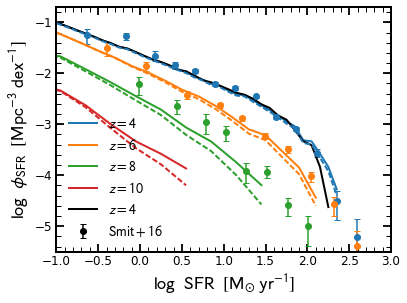

In [23]:
redshift_plot = ['4', '6', '8', '10']
color_plot = ['C0', 'C1', 'C2', 'C3']
label_plot = ['z=4: Smit+16', 'z=6: Smit+16', 'z=8: Smit+16']


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))

# Observations
for ii in range(len(redshift_plot))[:3]:
    plot_datapoints_observations(ax, SFRFct_obs_dict, redshift_plot[ii], color_plot[ii], '_nolegend_')

ax.errorbar(-99.0, -99.0, yerr=0.1, fmt='o', capsize=3, color='black', label=r'$\mathrm{Smit+16}$')

# Model
ax.plot(SFR_bins_center_z4, np.log10(SFR_fct_model_z4), '-', color=color_plot[0], lw=2, label=r'$z=4$')
ax.plot(SFR_bins_center_z6, np.log10(SFR_fct_model_z6), '-', color=color_plot[1], lw=2, label=r'$z=6$')
ax.plot(SFR_bins_center_z8, np.log10(SFR_fct_model_z8), '-', color=color_plot[2], lw=2, label=r'$z=8$')
ax.plot(SFR_bins_center_z10, np.log10(SFR_fct_model_z10), '-', color=color_plot[3], lw=2, label=r'$z=10$')

ax.plot(SFR_bins_center_z4_00, np.log10(SFR_fct_model_z4_00), '-', color='black', lw=2, label=r'$z=4$')


ax.plot(SFR_bins_center_z4_nocorr, np.log10(SFR_fct_model_z4_nocorr), '--', color=color_plot[0], lw=2)
ax.plot(SFR_bins_center_z6_nocorr, np.log10(SFR_fct_model_z6_nocorr), '--', color=color_plot[1], lw=2)
ax.plot(SFR_bins_center_z8_nocorr, np.log10(SFR_fct_model_z8_nocorr), '--', color=color_plot[2], lw=2)
ax.plot(SFR_bins_center_z10_nocorr, np.log10(SFR_fct_model_z10_nocorr), '--', color=color_plot[3], lw=2)


ax.set_xlabel(r'$\log\/\/\/\/\mathrm{SFR}\/\/\/\/[\mathrm{M_{\odot}}\/\/\mathrm{yr}^{-1}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\phi_{\rm SFR}\/\/\/\/[\mathrm{Mpc}^{-3}\/\/\mathrm{dex}^{-1}]$', fontsize=18)

ax.set_xlim([-1.0, 3.0])
ax.set_ylim([-5.5, -0.7])

plt.legend(frameon=False, fontsize=14)
plt.savefig(path_figures + 'SFR_Fct_evolution.pdf', bbox_inches='tight')
plt.show()


# Comparison Cosmic SFR Density

In [ ]:
# Oesch+18 integrates down to 0.3 Msun/yr, which corresponds to -17.0 mag
# this is probably not dust corrected, i.e. LF are integrated down to this magnitude
# we work with dust corrected quantities, i.e. we have to know to which dust corrected
# magnitude -17.0 goes to

def convert_mag_to_SFR(UVmag):
    Kuv_Oesch18 = 1.15*10**-28  # Msun/yr / erg/s/Hz
    L_1500 = np.power(10, -0.4*(UVmag+48.6))*4*np.pi*(3.086e+19)**2
    SFR = Kuv_Oesch18*L_1500
    return(SFR)
    

SFR_limit = 0.3


In [ ]:
# think about limiting mag...

print 'mag=-17.0 in SFR:', np.round(convert_mag_to_SFR(-17.0), 2)

mag_limit_z4 = add_dust_attenuation(-17.0, 4.0)
mag_limit_z6 = add_dust_attenuation(-17.0, 6.0)
mag_limit_z8 = add_dust_attenuation(-17.0, 8.0)
mag_limit_z10 = add_dust_attenuation(-17.0, 10.0)

print convert_mag_to_SFR(mag_limit_z4)
print convert_mag_to_SFR(mag_limit_z6)
print convert_mag_to_SFR(mag_limit_z8)
print convert_mag_to_SFR(mag_limit_z10)

# integrate LF down to SFR ~ 0.3 Msun/year ??
# check IMF
# get data

In [15]:
SFR_limit = 0.3


## Compute cSFRD from counting halos 

In [16]:
def compute_cSFRD(SP_file_name, SFR_limit_in, volume_box_in, redshift_in=None, completeness_correction=False, completeness_correction_type='parameterized'):
    '''
    Compute cosmic SFR density by counting SFR in individual halos.
    '''
    cat_SP = h5py.File(SP_file_name, 'r')
    SFR_list = compute_SFR(cat_SP, 200.0)
    idx = (SFR_list >= SFR_limit_in)
    if completeness_correction:
        if (completeness_correction_type=='numerical'):
            weights = 10**completeness.get_completeness_correction_numerical(np.log10(cat_SP['DM/DM_M'][:][idx]), redshift_in)
        elif (completeness_correction_type=='parameterized'):
            weights = 10**completeness.get_completeness_correction_parametrized(np.log10(cat_SP['DM/DM_M'][:][idx]), redshift_in)
    else:
        weights = 1.0    
    total_SFR = np.sum(weights*SFR_list[idx])
    total_SFRD = total_SFR/volume_box_in
    return(total_SFRD)
    
    

In [18]:
cSFRD_model_direct_z4 = compute_cSFRD(path_SP_cat_00 + 'SFH_z4_constant_with_L.hdf5', SFR_limit, volume_box, redshift_in=4.0, completeness_correction=True)
cSFRD_model_direct_z6 = compute_cSFRD(path_SP_cat_00 + 'SFH_z6_constant_with_L.hdf5', SFR_limit, volume_box, redshift_in=6.0, completeness_correction=True)
cSFRD_model_direct_z8 = compute_cSFRD(path_SP_cat_00 + 'SFH_z8_constant_with_L.hdf5', SFR_limit, volume_box, redshift_in=8.0, completeness_correction=True)
cSFRD_model_direct_z10 = compute_cSFRD(path_SP_cat_00 + 'SFH_z10_constant_with_L.hdf5', SFR_limit, volume_box, redshift_in=10.0, completeness_correction=True)

cSFRD_model_direct_z4_nocorr = compute_cSFRD(path_SP_cat_00 + 'SFH_z4_constant_with_L.hdf5', SFR_limit, volume_box)
cSFRD_model_direct_z6_nocorr = compute_cSFRD(path_SP_cat_00 + 'SFH_z6_constant_with_L.hdf5', SFR_limit, volume_box)
cSFRD_model_direct_z8_nocorr = compute_cSFRD(path_SP_cat_00 + 'SFH_z8_constant_with_L.hdf5', SFR_limit, volume_box)
cSFRD_model_direct_z10_nocorr = compute_cSFRD(path_SP_cat_00 + 'SFH_z10_constant_with_L.hdf5', SFR_limit, volume_box)


## Compute cSFRD from SFR functions

In [19]:
# model

idx = (10**SFR_bins_center_z4 >= SFR_limit)
cSFRD_model_z4 = np.trapz(SFR_fct_model_z4[idx]*1.0/10**SFR_bins_center_z4[idx], 10**SFR_bins_center_z4[idx])
idx = (10**SFR_bins_center_z6 >= SFR_limit)
cSFRD_model_z6 = np.trapz(SFR_fct_model_z6[idx]*1.0/10**SFR_bins_center_z6[idx], 10**SFR_bins_center_z6[idx])
idx = (10**SFR_bins_center_z8 >= SFR_limit)
cSFRD_model_z8 = np.trapz(SFR_fct_model_z8[idx]*1.0/10**SFR_bins_center_z8[idx], 10**SFR_bins_center_z8[idx])
idx = (10**SFR_bins_center_z10 >= SFR_limit)
cSFRD_model_z10 = np.trapz(SFR_fct_model_z10[idx]*1.0/10**SFR_bins_center_z10[idx], 10**SFR_bins_center_z10[idx])


# observations by Smit et al

idx = (SFR_list_z4 >= SFR_limit)
cSFRD_obs_Smit_z4 = np.trapz(SFR_fct_z4[idx]*1.0/SFR_list_z4[idx], SFR_list_z4[idx])
idx = (SFR_list_z6 >= SFR_limit)
cSFRD_obs_Smit_z6 = np.trapz(SFR_fct_z6[idx]*1.0/SFR_list_z6[idx], SFR_list_z6[idx])
idx = (SFR_list_z8 >= SFR_limit)
cSFRD_obs_Smit_z8 = np.trapz(SFR_fct_z8[idx]*1.0/SFR_list_z8[idx], SFR_list_z8[idx])

cSFRD_Smit = np.log10([cSFRD_obs_Smit_z4, cSFRD_obs_Smit_z6, cSFRD_obs_Smit_z8])


## Plot cSFRD 

In [20]:
# Oesch+18
z_list_obs = np.array([3.804, 4.902, 5.916, 6.805, 7.907, 10.195])
z_list_obs_low = np.array([3.396, 4.395, 5.487, 6.288, 7.391, 9.542])
z_list_obs_high = np.array([4.228, 5.426, 6.327, 7.335, 8.425, 10.860])
cSFRD_obs = np.array([-1.116, -1.389, -1.647, -1.880, -2.211, -3.289])
cSFRD_obs_low = np.array([-0.986, -1.267, -1.501, -1.811, -2.132, -3.112])
cSFRD_obs_high = np.array([-1.265, -1.517, -1.781, -1.965, -2.284, -3.471])

idx_S16 = np.array([True, False, True, False, True, False])


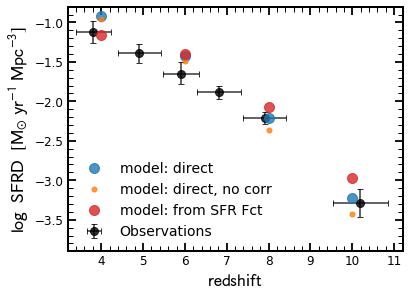

In [22]:
# make figure

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))

# Observations
ax.errorbar(z_list_obs, cSFRD_obs, xerr=[z_list_obs-z_list_obs_low, z_list_obs_high-z_list_obs], yerr=[cSFRD_obs-cSFRD_obs_low, cSFRD_obs_high-cSFRD_obs], fmt='o', ms=8, capsize=3.0, color='black', alpha=0.8, label='Observations')
#ax.errorbar(z_list_obs[idx_S16], cSFRD_Smit, xerr=[z_list_obs[idx_S16]-z_list_obs_low[idx_S16], z_list_obs_high[idx_S16]-z_list_obs[idx_S16]], fmt='o', ms=8, capsize=3.0, color='gray', alpha=0.8, label='Observations 2')

# Model
ax.plot(4.0, np.log10(cSFRD_model_direct_z4), 'o', color='C0', alpha=0.8, ms=10, zorder=10, label='model: direct')
ax.plot(6.0, np.log10(cSFRD_model_direct_z6), 'o', color='C0', alpha=0.8, ms=10, zorder=10)
ax.plot(8.0, np.log10(cSFRD_model_direct_z8), 'o', color='C0', alpha=0.8, ms=10, zorder=10)
ax.plot(10.0, np.log10(cSFRD_model_direct_z10), 'o', color='C0', alpha=0.8, ms=10, zorder=10)

ax.plot(4.0, np.log10(cSFRD_model_direct_z4_nocorr), '.', color='C1', alpha=0.8, ms=10, zorder=10, label='model: direct, no corr')
ax.plot(6.0, np.log10(cSFRD_model_direct_z6_nocorr), '.', color='C1', alpha=0.8, ms=10, zorder=10)
ax.plot(8.0, np.log10(cSFRD_model_direct_z8_nocorr), '.', color='C1', alpha=0.8, ms=10, zorder=10)
ax.plot(10.0, np.log10(cSFRD_model_direct_z10_nocorr), '.', color='C1', alpha=0.8, ms=10, zorder=10)

ax.plot(4.0, np.log10(cSFRD_model_z4), 'o', color='C3', alpha=0.8, ms=10, zorder=10, label='model: from SFR Fct')
ax.plot(6.0, np.log10(cSFRD_model_z6), 'o', color='C3', alpha=0.8, ms=10, zorder=10)
ax.plot(8.0, np.log10(cSFRD_model_z8), 'o', color='C3', alpha=0.8, ms=10, zorder=10)
ax.plot(10.0, np.log10(cSFRD_model_z10), 'o', color='C3', alpha=0.8, ms=10, zorder=10)

# add labels
ax.set_xlabel(r'$\mathrm{redshift}$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\mathrm{SFRD}\/\/\/\/[\mathrm{M_{\odot}}\/\/\mathrm{yr}^{-1}\/\/\mathrm{Mpc}^{-3}]$', fontsize=18)

ax.set_xlim([3.2, 11.2])
ax.set_ylim([-3.9, -0.8])

plt.legend(frameon=False, fontsize=14)
plt.savefig(path_figures + 'cSFRD_evolution.pdf', bbox_inches='tight')
plt.show()

